## Uncertainty example

\begin{align}
        p(\textbf{z}|c) &= \mathcal{C}_d(\kappa)\exp\left(\kappa\mu^T_{c}\textbf{z}\right)\\
        \mathcal{C}_d(\kappa) &= \frac{(\kappa)^{d/2-1}}{(2\pi)^{d/2}\mathcal{I}_{d/2-1}(\kappa)}
\end{align}

With d=2:

In [30]:
from scipy.special import iv, gamma
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np
import matplotlib as mpl

%load_ext autoreload
%autoreload 2

# mpl.style.use('classic')


def z_Prob(z, mus, kappa, d=2, beta=0.5):
    K = mus.shape[-1]
    p_c = (1 - beta) / K
    class_probs = np.array([z_vonMises_dencity(z, mu, kappa) for mu in mus.T])
    return np.sum(class_probs * p_c) + (1 / (2 * np.pi)) * beta


def z_class_prob(class_id, z, mus, kappa, d=2, beta=0.5):
    p_z = z_Prob(z, mus, kappa, d, beta)
    K = mus.shape[1]
    if class_id == K:
        p_c = beta
        return (1 / (2 * np.pi)) * p_c / p_z
    else:
        p_c = (1 - beta) / K
        return (z_vonMises_dencity(z, mus[:, class_id], kappa) * p_c) / p_z


def z_vonMises_dencity(z, mu_c, kappa, d=2):
    C_d = kappa ** (d / 2 - 1) / ((2 * np.pi) ** (d / 2) * iv(d / 2 - 1, kappa))
    return C_d * np.exp(kappa * np.dot(z, mu_c))


def z_power_dencity(z, mu_c, kappa, d=2):
    alpha = (d - 1) / 2 + kappa
    beta = (d - 1) / 2
    M_d = gamma(alpha + beta) / (2 ** (alpha + beta) * np.pi**beta * gamma(alpha))
    return M_d * (1 + np.dot(z, mu_c)) ** kappa

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def get_vectors_by_angle(angles):
    return np.array([[np.cos(plot_angle), np.sin(plot_angle)] for plot_angle in angles])


def compute_class_probs(class_id, zs, mus, kappa, beta):
    class_probes = []
    for z in zs:
        class_prob = z_class_prob(class_id, z, mus, kappa, beta=beta)
        class_probes.append(class_prob)
    class_probes = np.array(class_probes)
    return class_probes

In [3]:
def draw_circle(ax, linewidth, zorder=4):
    # plot circle
    theta = np.linspace(0, 2 * np.pi, 150)
    a = np.cos(theta)
    b = np.sin(theta)
    circle = plt.Circle((0, 0), 1, color="blue", zorder=4, alpha=0.1)
    ax.add_patch(circle)
    ax.plot(a, b, color="tab:gray", zorder=4, linewidth=linewidth)
    ax.axis("off")


def draw_decity(ax):
    pass


def draw_example(kappa, gallery_class_angles, text_shift, save_name, beta=0.5):
    fontsize = 20
    linewidth = 3
    dot_size = 80

    test_color = "tab:cyan"
    # gallery_class_angles = [0.4, 0.25]
    ident_uncertain_test_point = (
        gallery_class_angles[-1] + gallery_class_angles[-2]
    ) / 2 - 0.02
    test_points_angles = [
        ident_uncertain_test_point,
        gallery_class_angles[-1]
        - (ident_uncertain_test_point - gallery_class_angles[-1]),
    ]

    gallery_class_angles = np.array(gallery_class_angles) * 2 * np.pi
    test_points_angles = np.array(test_points_angles) * 2 * np.pi
    theta = np.linspace(0, 2 * np.pi, 150)

    colors = list(mcolors.TABLEAU_COLORS)[: len(gallery_class_angles)]

    fig, ax = plt.subplots(figsize=(5, 5))

    draw_circle(ax, linewidth)

    draw_dencity_angles = np.linspace(-np.pi / 3, np.pi / 3, 150)
    mus = np.stack([np.cos(gallery_class_angles), np.sin(gallery_class_angles)], axis=0)
    class_to_class_probs = []

    for i, (angle, color) in enumerate(zip(gallery_class_angles, colors)):
        mu_c = mus[:, i]
        plot_angles = angle + draw_dencity_angles
        zs = get_vectors_by_angle(plot_angles)
        class_probes = compute_class_probs(i, zs, mus, kappa, beta)
        v = zs.T * (1 + class_probes[np.newaxis, :])
        ax.plot(v[0], v[1], c=color, linewidth=linewidth)

        ax.scatter([np.cos(angle)], [np.sin(angle)], c=color, s=dot_size, zorder=5)
        ax.scatter([0], [0], color="black", s=20)

        # plot decity
        # ax.scatter(points[:, 0], points[:, 1], color=color, s=3)

    # plot_uniform_prob
    zs = get_vectors_by_angle(theta)
    class_probes = compute_class_probs(mus.shape[1], zs, mus, kappa, beta)
    v = zs.T * (1 + class_probes[np.newaxis, :])
    # ax.plot(v[0], v[1], color='black')

    # plot unc
    all_probs = []
    for i in range(mus.shape[1] + 1):
        class_probes = compute_class_probs(i, zs, mus, kappa, beta)
        all_probs.append(class_probes)
    all_probs = np.stack(all_probs, axis=0)
    unc = -np.sum(all_probs * np.log(all_probs), axis=0)
    # unc = -np.max(all_probs, axis=0) + 1
    v = zs.T * (1 + unc[np.newaxis, :])
    ax.plot(v[0], v[1], color="tab:red", linewidth=linewidth)

    # plot test points
    for test_angle in test_points_angles:
        ax.scatter(
            [np.cos(test_angle)],
            [np.sin(test_angle)],
            c=test_color,
            s=dot_size,
            zorder=5,
        )

    test_point_vectors = get_vectors_by_angle(test_points_angles)
    # entropy value

    probs_at_test_points = []
    for i in range(mus.shape[1] + 1):
        class_probes = compute_class_probs(i, test_point_vectors, mus, kappa, beta)
        probs_at_test_points.append(class_probes)
    probs_at_test_points = np.stack(probs_at_test_points, axis=0)

    unc_test = -np.sum(probs_at_test_points * np.log(probs_at_test_points), axis=0)
    unc_test = np.round(unc_test, 2)
    # unc_test = -np.max(probs_at_test_points, axis=0) + 1
    # unc_test = np.round(unc_test, 2)
    ax.annotate(
        f"${unc_test[0]}$",
        xy=test_point_vectors[0],
        xytext=[
            test_point_vectors[0][0] + text_shift[0][0],
            test_point_vectors[0][1] + text_shift[0][1],
        ],
        fontsize=fontsize,
    )
    ax.annotate(
        f"${unc_test[1]}$",
        xy=test_point_vectors[1],
        xytext=[
            test_point_vectors[1][0] + text_shift[1][0],
            test_point_vectors[1][1] + text_shift[1][1],
        ],
        fontsize=fontsize,
    )
    fig.gca().set_aspect("equal")
    plt.savefig(save_name, dpi=300, bbox_inches="tight")

In [4]:
# draw_example(
#     kappa=15,
#     gallery_class_angles=[0.4, 0.25],
#     text_shift=[[-0.2, -0.3], [-0.2, 0.1]],
#     save_name="test.png",
# )

### False Identification example

In [5]:
# draw_example(kappa = 15, gallery_class_angles = [0.4, 0.25], text_shift = [[-0.2, -0.3], [-0.2, 0.1]], save_name='/app/paper_assets/images/false_ident_example.png')

### False accept/reject example

In [6]:
# draw_example(kappa = 13, gallery_class_angles = [0.48, 0.25], text_shift = [[-0.1, -0.3], [-0.35, 0.2]], save_name='/app/paper_assets/images/false_accept-reject_example.png')

## Monte Carlo sampling

In [31]:
def draw_dencity(
    angle,
    kappa,
    ax,
    linewidth,
    color,
    range=np.pi / 3,
    scale=1,
    draw_center=False,
    dot_size=40,
    type="vMF",
):
    assert type in ["vMF", "power"]
    draw_dencity_angles = np.linspace(-range, range, 150)
    plot_angles = angle + draw_dencity_angles
    zs = get_vectors_by_angle(plot_angles)
    mu = get_vectors_by_angle([angle])[0]
    if type == "vMF":
        dencities = z_vonMises_dencity(zs, mu, kappa)
    else:
        dencities = z_power_dencity(zs, mu, kappa)
    v = zs.T * (1 + dencities * scale)
    ax.plot(v[0], v[1], c=color, linewidth=linewidth)
    if draw_center:
        ax.scatter([np.cos(angle)], [np.sin(angle)], c=color, s=dot_size, zorder=5)

In [62]:
from evaluation.samplers import random_VMF, VonMisesFisher

gallery_features = []  # N gallery samples X 512
gallery_unc_log = []  # N gallery samples X 1
gallery_subject_ids_sorted = []  # N gallery samples


class_center_angles = np.array([0, np.pi / 2, np.pi])
class_z_kappa = np.array([9, 6, 5])
colors = list(mcolors.TABLEAU_COLORS)[: len(class_center_angles)]


rng = np.random.default_rng(2)

for class_id, (angle, kappa) in enumerate(zip(class_center_angles, class_z_kappa)):
    num_samples = rng.integers(5, 8)
    gallery_subject_ids_sorted.extend([class_id] * num_samples)
    gallery_unc_log.extend(4 * rng.random(num_samples) + 2)
    samples = random_VMF(
        get_vectors_by_angle([angle])[0], kappa=kappa, size=num_samples
    )
    gallery_features.extend(samples)

gallery_features = np.array(gallery_features)
gallery_unc_log = np.array(gallery_unc_log).reshape(-1, 1)
gallery_subject_ids_sorted = np.array(gallery_subject_ids_sorted)

gallery_unc = np.exp(gallery_unc_log)

In [63]:
sampler = VonMisesFisher(3)
feature_mean = sampler(np.array([[0, 1], [1, 0]]), np.array([[10], [15]]))

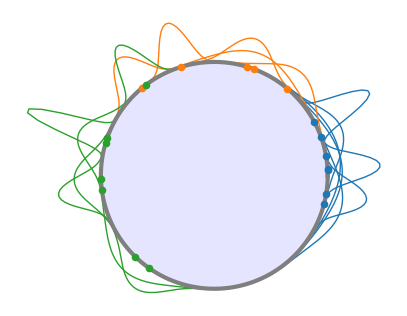

In [64]:
fontsize = 20
linewidth = 3
dot_size = 80
fig, ax = plt.subplots(figsize=(5, 5))
draw_circle(ax, linewidth)
for class_id, (angle, kappa) in enumerate(zip(class_center_angles, class_z_kappa)):
    color = colors[class_id]
    # draw_dencity(
    #     angle,
    #     kappa,
    #     ax,
    #     linewidth=3,
    #     color=color,
    #     range=np.pi / 2,
    #     draw_center=True,
    #     dot_size=dot_size,
    # )
    for position in np.where(gallery_subject_ids_sorted == class_id)[0]:
        point_angle = np.angle(
            [gallery_features[position][0] + 1j * gallery_features[position][1]]
        )[0]
        draw_dencity(
            point_angle,
            gallery_unc[position],
            ax,
            linewidth=1,
            color=color,
            range=np.pi / 2,
            scale=0.1,
            draw_center=True,
            dot_size=20,
        )
fig.gca().set_aspect("equal")
fig.show()
plt.savefig("/app/outputs/images/generation.png", dpi=300, bbox_inches="tight")

### Monte Carlo integration

In [65]:
import torch

gallery_features.shape
init_mean = np.array(
    [
        np.mean(gallery_features[gallery_subject_ids_sorted == c], axis=0)
        for c in range(3)
    ]
)
# init_mean = init_mean / np.linalg.norm(init_mean, axis=1, keepdims=True)

init_kappa = np.array(
    [np.mean(gallery_unc[gallery_subject_ids_sorted == c], axis=0) for c in range(3)]
)

In [66]:
gallery_features.shape, gallery_unc.shape

((19, 2), (19, 1))

In [67]:
from typing import Any
from scipy.special import ive, hyp0f1, loggamma


class MonteCarloPredictiveProb:
    def __init__(
        self,
        M: int,
        gallery_prior: str = "power",
        unc_model: str = "vMF",
        beta: float = 0.5,
    ) -> None:
        """
        params:
        M -- number of MC samples
        gallery_prior -- model for p(z|c)
        unc_model -- form of p(z|x)
        """
        self.M = M
        assert gallery_prior in ["power", "vMF"]
        assert unc_model in ["vMF", "PFE"]
        if unc_model == "vMF":
            self.sampler = VonMisesFisher(self.M)
        self.gallery_prior = gallery_prior
        self.unc_model = unc_model
        self.beta = beta

    def __call__(
        self,
        mean: np.array,
        kappa: np.array,
        gallery_means: torch.nn.Parameter,
        gallery_kappas: torch.nn.Parameter,
        T: torch.nn.Parameter,
    ) -> Any:
        self.K = gallery_means.shape[0]
        # print(self.K)
        zs = torch.tensor(self.sampler(mean, kappa))
        d = torch.tensor([mean.shape[-1]])
        # print(zs.shape, gallery_means.shape)
        # print(zs, gallery_means)
        similarities = zs @ gallery_means.T
        # print(similarities.shape)
        # print(similarities)
        if self.gallery_prior == "power":
            log_m_c_power = (
                torch.special.gammaln(d - 1 + gallery_kappas)
                + torch.special.gammaln(d / 2 + gallery_kappas)
                + gallery_kappas * np.log(2)
                - torch.special.gammaln(d / 2)
                - torch.special.gammaln(d - 1 + 2 * gallery_kappas)
            )
            m_c_power = torch.exp(log_m_c_power)
            log_uniform_dencity = (
                torch.special.gammaln(d / 2) - np.log(2) - (d / 2) * np.log(np.pi)
            )
            log_normalizer = log_m_c_power + log_uniform_dencity
        # compute log z prob
        p_c = ((1 - self.beta) / self.K) ** (1 / T)
        # print(similarities.shape, gallery_kappas.shape, log_uniform.shape, m_c_power.shape)
        logit_sum = (
            torch.sum(
                (m_c_power[..., :, 0] ** (1 / T))
                * ((1 + similarities) ** (gallery_kappas[..., :, 0] * (1 / T))),
                dim=-1,
            )
            * p_c
        )
        log_z_prob = (1 / T) * log_uniform_dencity + torch.log(
            logit_sum + (self.beta) ** (1 / T)
        )

        log_beta = np.log(self.beta)
        # print(similarities.shape, gallery_kappas.shape)
        uniform_log_prob = (1 / T) * (log_uniform_dencity + log_beta) - log_z_prob

        # compute gallery classes log prob
        pz_c = (
            torch.log((1 + similarities)) * gallery_kappas[..., :, 0]
            + log_normalizer[..., :, 0]
        )
        # print(pz_c.shape, log_z_prob.shape)
        gallery_log_probs = (1 / T) * (
            pz_c + np.log((1 - self.beta) / self.K)
        ) - log_z_prob[..., np.newaxis]
        # print(uniform_log_prob.shape)
        log_probs = torch.cat(
            [gallery_log_probs, uniform_log_prob[..., np.newaxis]], dim=-1
        )
        # print(log_probs.shape)
        # print(torch.sum(log_probs, dim=-1))
        return log_probs

In [78]:
import geotorch

nll_loss = torch.nn.NLLLoss()


class GalleryParams(torch.nn.Module):
    def __init__(self, init_mean, init_kappa):
        super(GalleryParams, self).__init__()
        self.gallery_means = torch.nn.Parameter(torch.tensor(init_mean))
        # self.gallery_kappas =  torch.nn.Parameter(torch.tensor(init_kappa))
        # self.gallery_means = torch.nn.Parameter(torch.rand(3, 2, dtype=torch.float64))
        self.gallery_kappas = torch.nn.Parameter(
            torch.rand(3, 1, dtype=torch.float64) * 10
        )


gallery_params = GalleryParams(init_mean, init_kappa)
target_class = torch.tensor(gallery_subject_ids_sorted)
T = torch.nn.Parameter(torch.tensor(1.0))
geotorch.sphere(gallery_params, "gallery_means")


# train
M = 10
mc_prob = MonteCarloPredictiveProb(M=M)

# optimizer = torch.optim.Adam([gallery_means, gallery_kappas], lr=10e-3)
optimizer = torch.optim.Adam(gallery_params.parameters(), lr=0.1)

num_steps = 450

for iter in range(num_steps):
    optimizer.zero_grad()
    # compute nll loss
    log_probs = mc_prob(
        gallery_features,
        gallery_unc,
        gallery_params.gallery_means,
        gallery_params.gallery_kappas,
        T,
    )[:, :, :-1]
    probs = torch.exp(log_probs)
    mean_probs = torch.mean(probs, axis=1)
    log_probs_new = torch.log(mean_probs)
    loss = nll_loss(log_probs_new, target_class)
    loss.backward()
    optimizer.step()
    print(gallery_params.gallery_means)
    print(torch.norm(gallery_params.gallery_means, dim=-1))
    print(gallery_params.gallery_kappas)
    print(f"Iteration {iter}, Loss: {loss.item()}")

tensor([[-0.4870,  0.8734],
        [-0.5543,  0.8323],
        [-0.8208, -0.5712]], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000], dtype=torch.float64,
       grad_fn=<LinalgVectorNormBackward0>)
Parameter containing:
tensor([[9.0284],
        [2.7930],
        [8.8899]], dtype=torch.float64, requires_grad=True)
Iteration 0, Loss: 5.055512716009559
tensor([[-0.3607,  0.9327],
        [-0.4335,  0.9011],
        [-0.8920, -0.4521]], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000], dtype=torch.float64,
       grad_fn=<LinalgVectorNormBackward0>)
Parameter containing:
tensor([[8.9289],
        [2.8590],
        [8.7921]], dtype=torch.float64, requires_grad=True)
Iteration 1, Loss: 4.414321656875508
tensor([[-0.2300,  0.9732],
        [-0.3098,  0.9508],
        [-0.9445, -0.3286]], dtype=torch.float64, grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000], dtype=torch.float64,
       grad_fn=<LinalgVectorNormBackward0>)
Parame

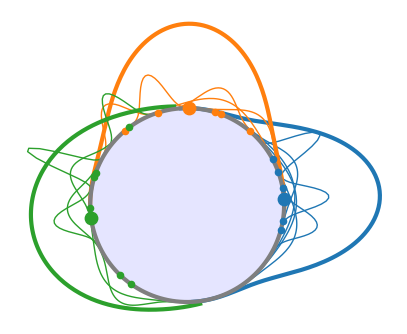

In [79]:
fontsize = 20
linewidth = 3
dot_size = 80
fig, ax = plt.subplots(figsize=(5, 5))
draw_circle(ax, linewidth)
for class_id, (class_mean, kappa) in enumerate(
    zip(gallery_params.gallery_means, gallery_params.gallery_kappas)
):
    color = colors[class_id]
    class_mean = class_mean.detach().numpy()
    kappa = kappa.detach().numpy()
    class_point_angle = np.angle([class_mean[0] + 1j * class_mean[1]])[0]
    draw_dencity(
        class_point_angle,
        kappa,
        ax,
        linewidth=3,
        color=color,
        range=np.pi / 2,
        draw_center=True,
        dot_size=dot_size,
        type="power",
    )
    for position in np.where(gallery_subject_ids_sorted == class_id)[0]:
        point_angle = np.angle(
            [gallery_features[position][0] + 1j * gallery_features[position][1]]
        )[0]
        draw_dencity(
            point_angle,
            gallery_unc[position],
            ax,
            linewidth=1,
            color=color,
            range=np.pi / 2,
            scale=0.1,
            draw_center=True,
            dot_size=20,
        )
fig.gca().set_aspect("equal")
fig.show()
plt.savefig("/app/outputs/images/trained.png", dpi=300, bbox_inches="tight")

### Test Probability estimation

In [113]:
test_angles = np.array([np.pi / 3])
test_vectors = get_vectors_by_angle(test_angles)
test_kappa = np.array([[10]])
M = 100
mc_prob = MonteCarloPredictiveProb(M=M)

log_probs = mc_prob(
    test_vectors,
    test_kappa,
    gallery_params.gallery_means,
    gallery_params.gallery_kappas,
    T,
)  # [:, :, :-1]
probs = torch.exp(log_probs)
mean_probs = torch.mean(probs, axis=1)

In [114]:
mean_probs

tensor([[0.1303, 0.4251, 0.0018, 0.4428]], dtype=torch.float64,
       grad_fn=<MeanBackward1>)

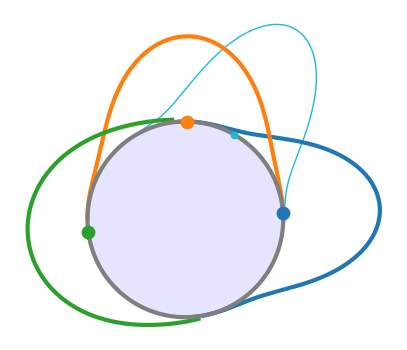

In [121]:
fontsize = 20
linewidth = 3
dot_size = 80
fig, ax = plt.subplots(figsize=(5, 5))
draw_circle(ax, linewidth)
draw_dencity(
    test_angles[0],
    test_kappa[0],
    ax,
    linewidth=1,
    color="tab:cyan",
    range=np.pi / 2,
    scale=1,
    draw_center=True,
    dot_size=20,
)
for class_id, (class_mean, kappa) in enumerate(
    zip(gallery_params.gallery_means, gallery_params.gallery_kappas)
):
    color = colors[class_id]
    class_mean = class_mean.detach().numpy()
    kappa = kappa.detach().numpy()
    class_point_angle = np.angle([class_mean[0] + 1j * class_mean[1]])[0]
    draw_dencity(
        class_point_angle,
        kappa,
        ax,
        linewidth=3,
        color=color,
        range=np.pi / 2,
        draw_center=True,
        dot_size=dot_size,
        type="power",
    )
fig.gca().set_aspect("equal")
fig.show()
plt.savefig("/app/outputs/images/test.png", dpi=300, bbox_inches="tight")

In [117]:
colors

['tab:blue', 'tab:orange', 'tab:green']